In [1]:
import math
import torch
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import torch.profiler as profiler
from tensorboardX import SummaryWriter
import datetime
import warnings
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from typing import Optional, Tuple
warnings.filterwarnings('ignore')

# Retrieve data

In [4]:
parquet_file = '../data/D16.04.25G04.24.16.26.19.parquet'
df_by_store = pd.read_parquet(parquet_file)
df_by_store

,date,resource_id,earnings
0,2016-04-25,1,204091.599570
1,2016-04-25,2,145476.503988
2,2016-04-25,3,83537.048125
3,2016-04-25,4,50666.284179
4,2016-04-25,5,40513.241215
...,...,...,...
0,2021-04-23,1,49277.046649
1,2021-04-23,2,119250.287098
2,2021-04-23,3,78128.432672
3,2021-04-23,4,20863.805292


In [5]:
writer = SummaryWriter('logs')

Text(0, 0.5, 'Earnings')

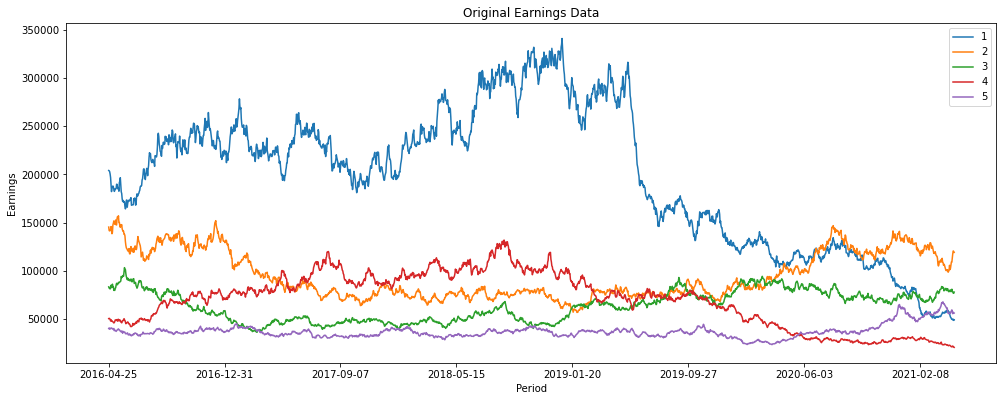

In [6]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_by_store.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')

## Start with Aggregate Data

In [7]:
# get cumulative earnings into sequence
df_stores_total_daily = df_by_store.groupby(by=['date']).sum()['earnings'].reset_index()
df_stores_total_daily.head()

,date,earnings
0,2016-04-25,524284.677077
1,2016-04-26,518631.893148
2,2016-04-27,517662.792609
3,2016-04-28,513351.767304
4,2016-04-29,511950.989776


In [8]:
df_stores_total_daily['Year'] = pd.to_datetime(df_stores_total_daily['date']).dt.year
df_stores_total_daily['Month'] = pd.to_datetime(df_stores_total_daily['date']).dt.month
df_stores_total_daily['WeekOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day.apply(lambda day: math.ceil(int(day)/7))
df_stores_total_daily['WeekOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.week
df_stores_total_daily['DayOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day
df_stores_total_daily['DayOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.dayofyear

df_stores_total_daily.head()

,date,earnings,Year,Month,WeekOfMonth,WeekOfYear,DayOfMonth,DayOfYear
0,2016-04-25,524284.677077,2016,4,4,17,25,116
1,2016-04-26,518631.893148,2016,4,4,17,26,117
2,2016-04-27,517662.792609,2016,4,4,17,27,118
3,2016-04-28,513351.767304,2016,4,4,17,28,119
4,2016-04-29,511950.989776,2016,4,5,17,29,120


In [9]:
# get cumulative earnings into sequence
df_stores_total_monthly = df_stores_total_daily.groupby(by=['Month','Year']).sum()['earnings'].reset_index()
df_stores_total_monthly.head()

,Month,Year,earnings
0,1,2017,1.613458e+07
1,1,2018,1.460313e+07
2,1,2019,1.651412e+07
3,1,2020,1.173956e+07
4,1,2021,1.151629e+07


Text(0, 0.5, 'Earnings')

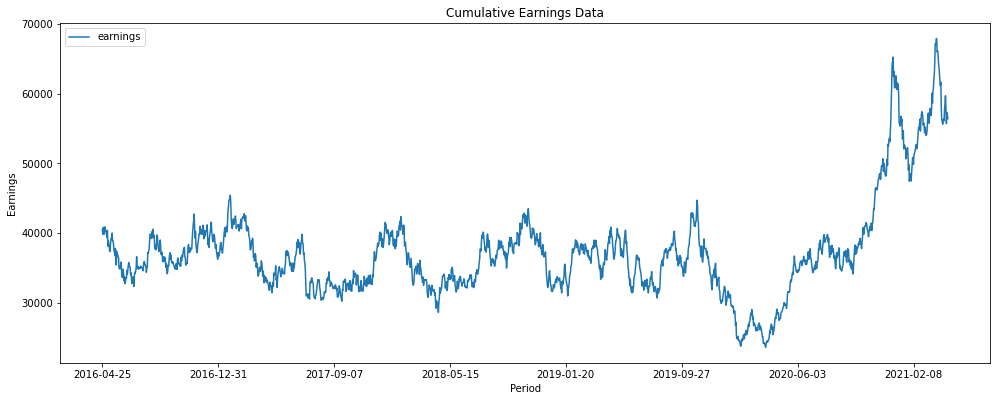

In [10]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = grp.plot(ax=ax, kind='line', x='date', y='earnings')
leg = ax.legend()
plt.title(f'Cumulative Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')


Text(0, 0.5, 'Earnings')

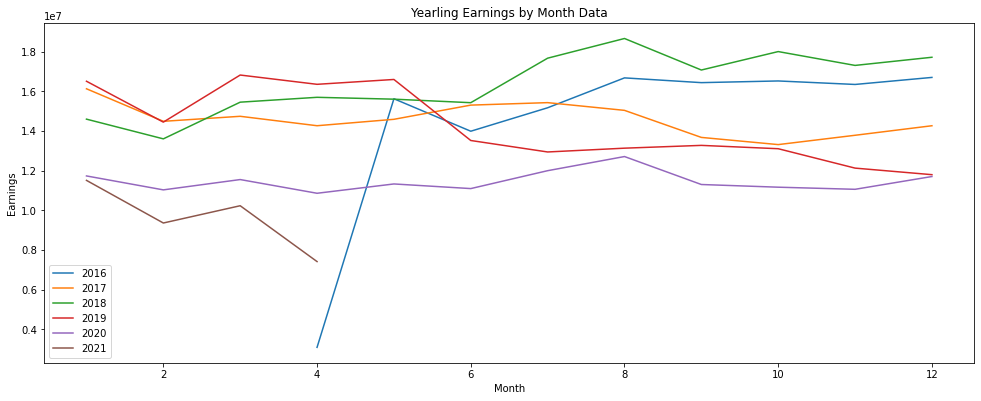

In [11]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_stores_total_monthly.groupby(['Year']):
    ax = grp.plot(ax=ax, kind='line', x='Month', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Yearling Earnings by Month Data')
plt.xlabel('Month')
plt.ylabel('Earnings')

# Split Data

In [12]:
#split data
data_all = df_stores_total_daily.earnings
sz = len(data_all)
test_sz = math.floor(.2 * sz)
sz, test_sz

(1825, 365)

In [13]:
train_data = data_all[:-test_sz]
test_data = data_all[-test_sz:]
len(train_data)+len(test_data), len(test_data)

(1825, 365)

In [14]:
msmin, msmax = train_data.min(), train_data.max()
print(f'Min: {msmin}, Max: {msmax}')
train_data_scaled = (train_data - msmin) / (msmax - msmin)

Min: 355379.73648441746, Max: 625030.780834687


Text(0, 0.5, 'Earnings')

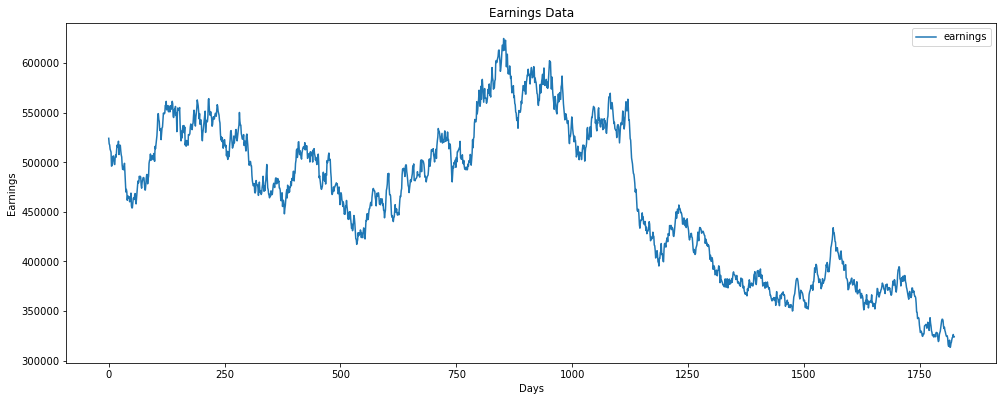

In [15]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = data_all.plot(ax=ax, kind='line', x='days', y='earnings')
leg = ax.legend()
plt.title(f'Earnings Data')
plt.xlabel('Days')
plt.ylabel('Earnings')



# Create Dataset with Lookback

In [16]:
# lookback window
window = 100

In [17]:
class SeqDataset(Dataset):
    def __init__(self, sequence: torch.Tensor, window: int) -> None:
        self.sz = len(sequence) - window
        self.win = window
        self.seq = sequence

    def __len__(self) -> int:
        return self.sz

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        e = i + self.win
        return self.seq[i:e], self.seq[e:e+1]

    def scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence - min) / (max - min)

    def inverse_scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence*(max - min)) + min



In [18]:
# min/max for scaling
cmin, cmax = data_all.min(), data_all.max()
print(f'{cmin} to {cmax}')
metadata = { 
    "min": float(cmin), 
    "max": float(cmax), 
    "window": window 
}
# scale
data_all = SeqDataset.scale(data_all, cmin, cmax)
# data split
test_sz = math.floor(0.20 * len(data_all))
train_data = torch.FloatTensor(data_all[:-test_sz])
val_data = torch.FloatTensor(data_all.to_numpy()[-test_sz:])
# create sequence datasets
train_dataset = SeqDataset(train_data, window)
val_dataset = SeqDataset(val_data, window)

313315.7295598695 to 625030.780834687


In [19]:
trainloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)

# Model

In [20]:
# Model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [21]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x.view(-1, x.size(1), 1), (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [22]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [25]:
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
        ],
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=3,
        active=6),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs',"test"),
    record_shapes=True
) as p:


    for step, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device=device), data[1].to(device=device)
        y_train_pred = model(inputs)
        loss = criterion(y_train_pred, labels)
        print("Step ", step, "MSE: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        writer.add_scalar('GRU Training Loss', loss.item(), step)
        p.step()

Epoch  0 MSE:  0.06502962857484818
Epoch  1 MSE:  0.11183540523052216
Epoch  2 MSE:  0.03818150982260704
Epoch  3 MSE:  0.04258372262120247
Epoch  4 MSE:  0.05424177646636963
Epoch  5 MSE:  0.08032898604869843
Epoch  6 MSE:  0.03625545650720596
Epoch  7 MSE:  0.03156290203332901
Epoch  8 MSE:  0.03263653442263603
Epoch  9 MSE:  0.0571296252310276
Epoch  10 MSE:  0.050368599593639374
Epoch  11 MSE:  0.017322475090622902
Epoch  12 MSE:  0.0171038918197155
Epoch  13 MSE:  0.025144539773464203
Epoch  14 MSE:  0.025417953729629517
Epoch  15 MSE:  0.025132793933153152
Epoch  16 MSE:  0.018409300595521927
Epoch  17 MSE:  0.012716214172542095
Epoch  18 MSE:  0.012981186620891094
Epoch  19 MSE:  0.009556682780385017
Epoch  20 MSE:  0.010877386666834354
Epoch  21 MSE:  0.008994312956929207
Epoch  22 MSE:  0.006418886594474316
Epoch  23 MSE:  0.0030250363051891327
Epoch  24 MSE:  0.0034854549448937178
Epoch  25 MSE:  0.004375439137220383
Epoch  26 MSE:  0.002514228457584977
Epoch  27 MSE:  0.0008

In [27]:

## Use profiler to analyze execution time
#
#input = test_data[0]
#with profiler.profile(record_shapes=True) as prof:
#    with profiler.record_function("model_inference"):
#        model(y_train.to(device))
#prof.export_chrome_trace("logs/trace.json")

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         6.19%     442.000us        99.50%       7.104ms       7.104ms       0.000us         0.00%     190.000us     190.000us             1  
                                              aten::gru         0.90%      64.000us        49.51%       3.535ms       3.535ms       0.000us         0.00%     116.000us     116.000us             1  
         

In [ ]:
writer.close()